# Triple Barrier Labeling
1. Load the price data
2. Volatility calculation and event extraction
3. Fixed time horizon labeling
4. Triple barrier labeling
5. Confirmation labeling
6. Plotting and visualization

In [1]:
import pandas as pd
from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.patches as patches
from pandas.tseries.offsets import DateOffset
import plotly.graph_objects as go
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

In [2]:
plt.style.use('default')

### Load the price data

In [3]:
price_df = pd.read_csv("../raw/daily-2020.csv", usecols=["timestamp", "close", "open", "high", "low", "volume"])
price_df.set_index('timestamp', inplace=True)
price_df.index = pd.to_datetime(price_df.index, unit='s')

### Volatility calculation and event extraction

In [4]:
def get_daily_vol(close, span0=100):
    """
    Calculate the daily volatility of closing prices.
    
    Parameters:
    - close: A pandas Series of closing prices.
    - span0: The span for the EWM standard deviation.
    
    Returns:
    - A pandas Series of daily volatility estimates.
    """
    # Find the start of the previous day for each day
    prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    prev_day_start = prev_day_start[prev_day_start > 0]
    
    # Create a series with the start of the previous day for each day
    prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])
    
    # Calculate daily returns
    daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1
    
    # Calculate EWM standard deviation of daily returns
    daily_vol = daily_returns.ewm(span=span0).std()
    
    return daily_returns, daily_vol

In [5]:
price_df["daily_returns"], price_df["volatility"] = get_daily_vol(price_df.close)

In [6]:
price_df.dropna(inplace=True)

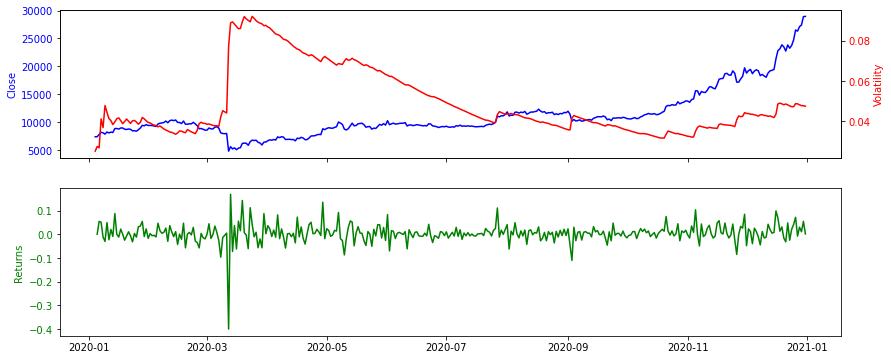

In [7]:
# Calculate returns
price_df['returns'] = price_df['close'].pct_change()

# Create a new figure with two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))

# Convert Series to NumPy arrays before plotting
index_array = price_df.index.to_numpy()
close_array = price_df['close'].to_numpy()
volatility_array = price_df['volatility'].to_numpy()
returns_array = price_df['returns'].to_numpy()

# Plot 'close' on the primary y-axis of the first subplot
ax1.plot(index_array, close_array, color='blue')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'volatility' on the first subplot
ax2 = ax1.twinx()
ax2.plot(index_array, volatility_array, color='red')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot 'returns' on the second subplot
ax3.plot(index_array, returns_array, color='green')
ax3.set_ylabel('Returns', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Show the plot
plt.show()

In [8]:
def get_t_events(raw_price, volatility, base_threshold):
    """
    :param raw_price: (series) of close prices.
    :param volatility: (series) of volatility values.
    :param base_threshold: (float) base level for the threshold.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events, s_pos, s_neg = [], 0, 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        # Adjust the threshold based on volatility
        threshold = base_threshold * volatility.loc[i]
        
        s_pos = max(0.0, float(s_pos + diff.loc[i]))
        s_neg = min(0.0, float(s_neg + diff.loc[i]))

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [9]:
events = get_t_events(price_df.close, price_df.volatility, 2)

Applying Symmetric CUSUM filter.


  0%|          | 0/361 [00:00<?, ?it/s]

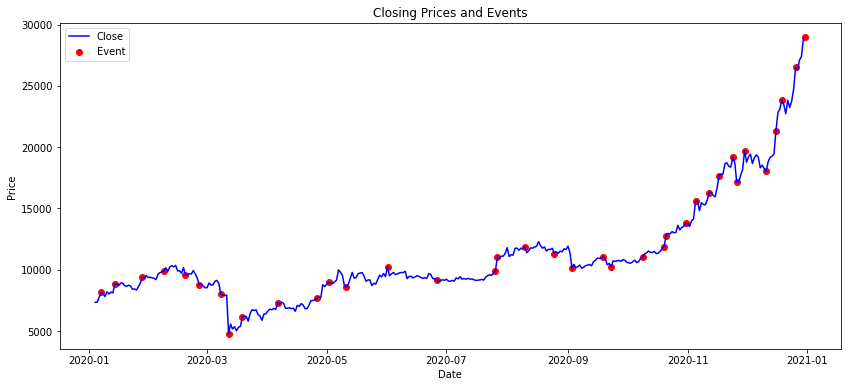

In [10]:
# Plot the closing prices
plt.subplots(figsize=(14, 6))
plt.plot(index_array, close_array, color='blue', label='Close')

# Add dots for the event dates
plt.scatter(events, price_df.loc[events, 'close'], color='red', label='Event')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Prices and Events')
plt.legend()

# Show the plot
plt.show()

### Fixed time horizon labeling

In [11]:
def fixed_time_horizon_labeling(price_series, h):
    """
    Perform fixed time horizon labeling on a price series.
    
    Parameters:
    - price_series: A pandas Series of prices.
    - h: The bar horizon.
    
    Returns:
    - A pandas Series of labels (-1, 0, 1).
    """
    # Split the price series into non-overlapping windows of size h
    windows = [price_series[i:i+h] for i in range(0, len(price_series), h)]
    
    # Initialize an empty list to store the labels
    labels = []
    
    # For each window, compare the last item with the first item and assign a label accordingly
    for window in windows:
        # print("last candle in window: ", window.iloc[-1], "first candle in window: ", window.iloc[0], window.iloc[-1] > window.iloc[0])
        if len(window) == h:  # Ensure the window is of size h
            if window.iloc[-1] > window.iloc[0]:
                labels.extend([1]*h)  # Bullish
            elif window.iloc[-1] < window.iloc[0]:
                labels.extend([-1]*h)  # Bearish
            else:
                labels.extend([0]*h)  # Neutral
    
    # Convert the list of labels into a pandas Series
    labels = pd.Series(labels, index=price_series.index[:len(labels)])
    
    return labels

In [12]:
def band_generator(labels):
    bands = [{'label': labels.iloc[0], 'from': labels.index[0]}]
    for l, i in enumerate(labels):
        if i == bands[-1]["label"]:
            pass
        else:
            bands[-1]["to"] = labels.index[l]
            # Check if l + 1 is within the range of the labels' indices
            if l + 1 < len(labels):
                bands.append({'label': i, 'from': labels.index[l + 1]})
    
    # Check if the last band has a 'to' field
    if 'to' not in bands[-1]:
        bands[-1]['to'] = labels.index[-1]
    
    return bands

In [13]:
def plot_labels(price_series, labels):
    """
    Plot price series with bullish and bearish areas.
    
    Parameters:
    - price_series: A pandas Series of prices.
    - labels: A pandas Series of labels (-1, 0, 1).
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()
    
    # Plot the price series
    ax1.plot(price_series.index.to_numpy(), price_series.values, label='Price', color='blue')
    
    # Draw a box for each window
    for label in labels:
        # Shift "from" and "to" by half a day
        from_timestamp = label["from"] - DateOffset(hours=12)
        to_timestamp = label["to"] + DateOffset(hours=12)
        
        # Ensure the timestamps are within the price series index
        from_timestamp = max(from_timestamp, price_series.index[0])
        to_timestamp = min(to_timestamp, price_series.index[-1])
        
        # Add the band
        ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color='green' if label["label"] == 1 else "red" if label["label"] == -1 else 'white' , alpha=0.3)

    # Add a legend
    ax1.legend()
    
    # Show the plot
    plt.show()

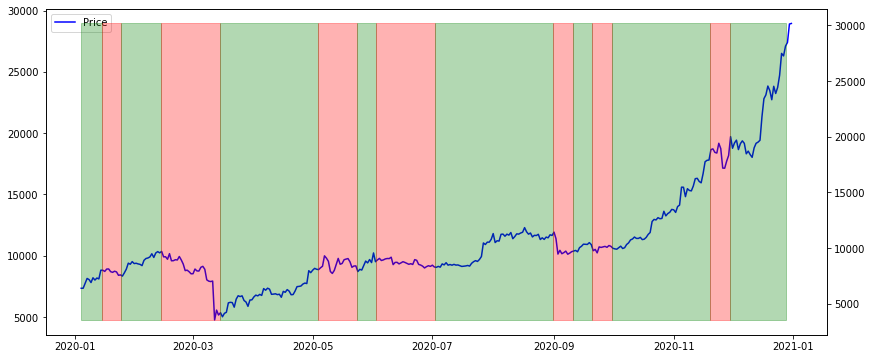

In [14]:
labels = fixed_time_horizon_labeling(price_df.close, 10)
bands = band_generator(labels)
plot_labels(price_df.close, bands)

In [15]:
labels.value_counts()

 1    240
-1    120
Name: count, dtype: int64

In [16]:
price_df["labels"] = labels

### Triple barrier labeling

In [17]:
# Define labels as named constants for readability
LABEL_UP = 1
LABEL_DOWN = -1
LABEL_NEUTRAL = 0

In [18]:
def calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type='volatility'):
    end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

    # Calculate the mean volatility or daily returns over the volatility_period
    if barrier_type == 'volatility':
        mean_value = df.loc[i-volatility_period+1:i, 'volatility'].mean()
        current_value = df.loc[i, 'volatility']
    elif barrier_type == 'returns':
        mean_value = df.loc[i-volatility_period+1:i, 'daily_returns'].mean()
        current_value = df.loc[i, 'daily_returns']
    else:
        raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

    df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * upper_barrier_factor)
    df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * lower_barrier_factor)
    return df

In [19]:
def label_observations(df, origin, i, label):
    df.loc[origin:i+1, 'labels'] = label
    return df

In [20]:
def triple_barrier_labeling(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL"):
    df = sdf.copy()
    df = df.reset_index()
    
    # Initialize labels and window start
    df['labels'] = LABEL_NEUTRAL
    df['window_start'] = False

    window = vertical_barrier
    origin = 0
    touch_upper = lambda high, barrier: high >= barrier
    touch_lower = lambda low, barrier: low <= barrier
    # For each observation
    for i in range(0, len(df)):
        # Define your barriers at the beginning of each window
        if i == origin:
            df = calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type)
            df.loc[i, 'window_start'] = True  # Mark the start of the window

        # one of the conditions were met
        if touch_upper(df.loc[i, "high" if touch_type == 'HL' else 'close'], df.loc[i, "upper_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_UP)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier
        elif touch_lower(df.loc[i, "low" if touch_type == 'HL' else 'close'], df.loc[i, "lower_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_DOWN)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier

        # none of the conditions were met
        else:
            if window > 0:
                # reduce window size by one
                window = window - 1
            else:
                # reset window
                window = vertical_barrier
                # label neutral from origin to origin + window
                df.loc[origin:min(origin+window, len(df)-1), 'labels'] = LABEL_NEUTRAL  # Ensure the window does not exceed the dataframe
                # set origin to the next id
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index

    df = df.set_index("timestamp")
    return df

In [21]:
tbl_df = triple_barrier_labeling(price_df, volatility_period=10, upper_barrier_factor=1.5, lower_barrier_factor=1.2, vertical_barrier=7, min_trend_days=2, barrier_type='volatility')

In [22]:
tbl_df.labels.value_counts()

labels
 1    152
 0    146
-1     65
Name: count, dtype: int64

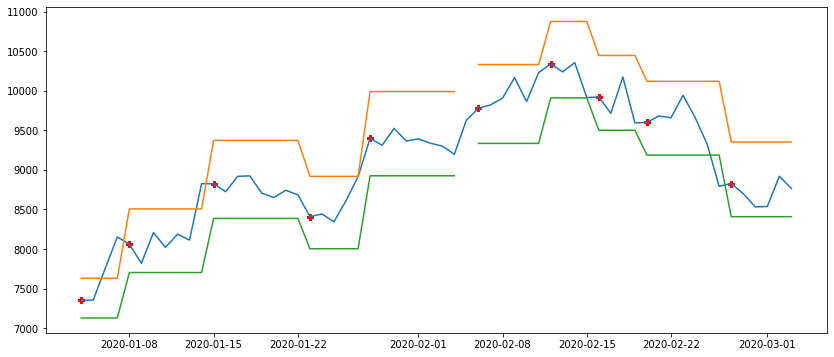

In [23]:
plot_df = tbl_df[0:60]
# Create a new DataFrame where 'window_start' is True
window_starts = plot_df[plot_df['window_start']]

plt.subplots(figsize=(14, 6))

# Plot the 'close', 'upper_barrier', and 'lower_barrier' columns
plt.plot(plot_df.index.to_numpy(), plot_df[['close', 'upper_barrier', 'lower_barrier']].to_numpy(), ms=1)

# Add markers at the start of each window
plt.scatter(window_starts.index, window_starts['close'], color='red', marker="P")

plt.show()

In [24]:
tbl_df.shape

(363, 12)

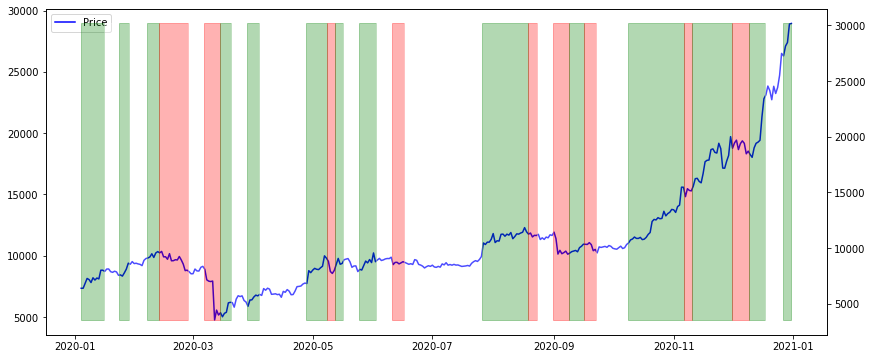

In [25]:
prices = tbl_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

### Confirmations labeling

In [26]:
def market_confirmed_labels(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7):
    df = sdf.reset_index()
    df['up_confirmed'] = False
    df['down_confirmed'] = False
    df['neutral_confirmed'] = False
    df['window_start'] = False
    df['upper_barrier'] = np.nan
    df['lower_barrier'] = np.nan

    i = volatility_period  # Start after the volatility_period

    while i < len(df):
        # Calculate the mean volatility over the specified period
        mean_volatility = df.loc[i-volatility_period:i-1, 'volatility'].mean()
        
        # Set barriers at the start of each window
        upper_barrier = df.loc[i, 'close'] * (1 + mean_volatility * upper_barrier_factor)
        lower_barrier = df.loc[i, 'close'] * (1 - mean_volatility * lower_barrier_factor)

        end_window = min(i + vertical_barrier, len(df))
        
        # Assign barriers to the entire window, ensuring they do not change within the window
        df.loc[i:end_window-1, 'upper_barrier'] = upper_barrier
        df.loc[i:end_window-1, 'lower_barrier'] = lower_barrier

        window = df.loc[i:end_window-1]

        # Determine labels for the window
        up_confirmed = window['high'].max() >= upper_barrier
        down_confirmed = window['low'].min() <= lower_barrier
        end_price = df.loc[end_window-1, 'close']
        neutral_confirmed = (end_price < upper_barrier) and (end_price > lower_barrier)

        df.loc[i, 'up_confirmed'] = up_confirmed
        df.loc[i, 'down_confirmed'] = down_confirmed
        df.loc[i, 'neutral_confirmed'] = neutral_confirmed

        df.loc[i, 'window_start'] = True
        
        # print(f"Window {i} to {end_window-1}:")
        # print(f"  Upper barrier: {upper_barrier}")
        # print(f"  Lower barrier: {lower_barrier}")
        # print(f"  Up confirmed: {up_confirmed}")
        # print(f"  Down confirmed: {down_confirmed}")
        # print(f"  Neutral confirmed: {neutral_confirmed}")
        
        # Move to the next window
        i += vertical_barrier

    df.set_index('timestamp', inplace=True)
    return df


In [54]:
def plot_confirmed_labels(df, vertical_barrier=7):
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    df_index_array = df.index.to_numpy()
    df_close_array = df['close'].to_numpy()
    df_upper_barrier_array = df['upper_barrier'].to_numpy()
    df_lower_barrier_array = df['lower_barrier'].to_numpy()

    ax1.plot(df_index_array, df_close_array, label='Price', color='blue')
    ax1.plot(df_index_array, df_upper_barrier_array, label='Upper Barrier', color='green', linestyle='--')
    ax1.plot(df_index_array, df_lower_barrier_array, label='Lower Barrier', color='red', linestyle='--')

    for i in range(0, len(df), vertical_barrier):
        if df.iloc[i]['window_start']:
            from_timestamp = df.index[i]
            to_timestamp = df.index[min(i + vertical_barrier, len(df) - 1)]

            up_confirmed = df.iloc[i]['up_confirmed']
            down_confirmed = df.iloc[i]['down_confirmed']
            neutral_confirmed = df.iloc[i]['neutral_confirmed']

            if up_confirmed and down_confirmed and neutral_confirmed:
                color = 'yellow'
                label = 'UP & DOWN & Neutral'
            elif up_confirmed and down_confirmed:
                color = 'orange'
                label = 'UP & DOWN'
            elif up_confirmed and neutral_confirmed:
                color = 'lightgreen'
                label = 'UP & Neutral'
            elif down_confirmed and neutral_confirmed:
                color = 'pink'
                label = 'DOWN & Neutral'
            elif up_confirmed:
                color = 'green'
                label = 'UP'
            elif down_confirmed:
                color = 'red'
                label = 'DOWN'
            else:
                color = 'white'
                label = 'Neutral'

            ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color=color, alpha=0.3)

            # Add markers only if the DataFrame size is less than 80
            if len(df) < 100:
                if up_confirmed:
                    ax1.plot(df.index[i], df.iloc[i]['upper_barrier'], 'go')
                if down_confirmed:
                    ax1.plot(df.index[i], df.iloc[i]['lower_barrier'], 'ro')
                if neutral_confirmed:
                    ax1.plot(df.index[i], df.iloc[i]['close'], 'bs')

                # Add breakpoints for the barriers
                window = df.iloc[i:min(i + vertical_barrier, len(df))]
                upper_crossings = window[window['high'] >= window['upper_barrier']]
                lower_crossings = window[window['low'] <= window['lower_barrier']]
                for idx in upper_crossings.index:
                    ax1.plot(window.loc[idx].name, window.loc[idx, 'upper_barrier'], 'gx')
                for idx in lower_crossings.index:
                    ax1.plot(window.loc[idx].name, window.loc[idx, 'lower_barrier'], 'rx')

    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    patch1 = mpatches.Patch(color='yellow', label='UP & DOWN & Neutral')
    patch2 = mpatches.Patch(color='orange', label='UP & DOWN')
    patch3 = mpatches.Patch(color='lightgreen', label='UP & Neutral')
    patch4 = mpatches.Patch(color='pink', label='DOWN & Neutral')
    patch5 = mpatches.Patch(color='green', label='UP')
    patch6 = mpatches.Patch(color='red', label='DOWN')
    patch7 = mpatches.Patch(color='white', label='Neutral')

    ax2.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7], loc='upper left', prop={'size': 6})

    plt.show()


In [55]:
conf_df = market_confirmed_labels(price_df)

In [56]:
conf_df['neutral_confirmed'].value_counts()

neutral_confirmed
False    337
True      26
Name: count, dtype: int64

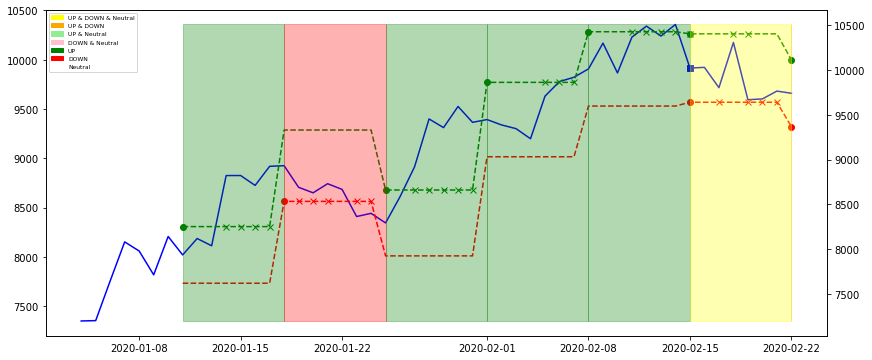

In [63]:
plot_confirmed_labels(conf_df[:50])

### Next day labeling

In [31]:
next_vola_df = triple_barrier_labeling(price_df, volatility_period=7, upper_barrier_factor=0.5, lower_barrier_factor=0.5, vertical_barrier=1, min_trend_days=0, touch_type='close')

In [32]:
next_vola_df.labels.value_counts()

labels
 0    240
 1     75
-1     48
Name: count, dtype: int64

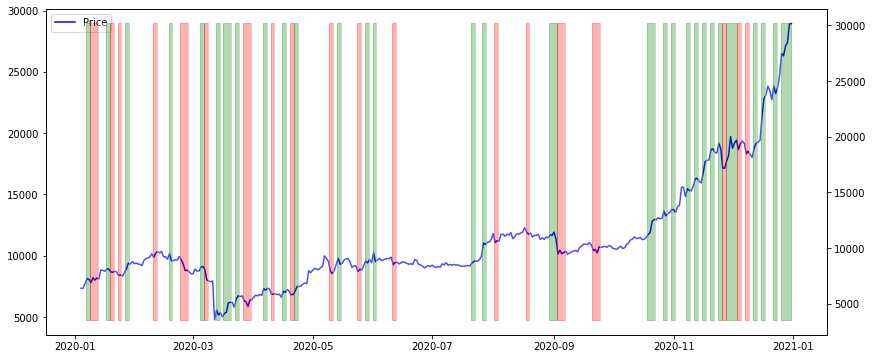

In [33]:
prices = next_vola_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

In [34]:
next_ret_df = triple_barrier_labeling(price_df, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=2, min_trend_days=0, barrier_type='returns', touch_type='close')

In [35]:
next_ret_df.labels.value_counts()

labels
 1    168
 0    132
-1     63
Name: count, dtype: int64

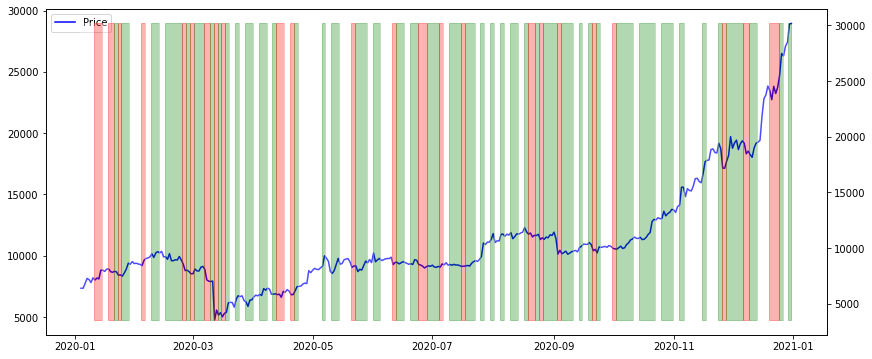

In [36]:
prices = next_ret_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

### Plotting and Visualization

In [37]:
import mplfinance as mpf
def plot_first_window(df, volatility_period=7, points_before=10, points_after=10):
    """
    Plot the first window in the dataset.
    
    Parameters:
    - df: A pandas DataFrame with 'open', 'high', 'low', 'close', 'upper_barrier', and 'lower_barrier' columns.
    - volatility_period: The number of periods used to calculate volatility.
    - points_before: The number of points before the window to display.
    - points_after: The number of points after the window to display.
    """
    # Find the first window
    first_window_start = df[df['window_start']].index[2]
    first_window_end = df[df['window_start']].index[3] if len(df[df['window_start']]) > 1 else df.index[-1]

    # Calculate the start and end of the plot
    plot_start = max(first_window_start - pd.Timedelta(points_before, unit='D'), df.index[0])
    plot_end = min(first_window_end + pd.Timedelta(points_after, unit='D'), df.index[-1])

    # Extract the data to plot
    plot_data = df.loc[plot_start:plot_end]

    # Create a new Series for window starts
    scatter_series = plot_data['close'].where(plot_data['window_start'])

    # Create additional plots for the upper and lower barriers
    addplot = [mpf.make_addplot(plot_data['upper_barrier'], color='green'),
               mpf.make_addplot(plot_data['lower_barrier'], color='red'),
               mpf.make_addplot(plot_data['volatility'].rolling(2).mean(), color='yellow'),
               mpf.make_addplot(scatter_series, color='red', type='scatter', label="added scatter")]

    # Create a new figure
    fig, axes = mpf.plot(plot_data, type='candle', style='yahoo', addplot=addplot, returnfig=True, figratio=(25,10))
    # Get the axis
    ax = axes[0]
    ax2 = axes[1]

    # ax2.fill_betweenx(ax.get_ylim(), first_window_start, first_window_end, color='green', alpha=0.3)

    # Set x-axis to show every two days
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add an annotation at the end of the first window
    ax.annotate('Window End', xy=(first_window_end, df.loc[first_window_end, 'close']), xytext=(-15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='->'))

    # Remove grid lines
    ax.grid(False)

    # Show the plot
    plt.show()

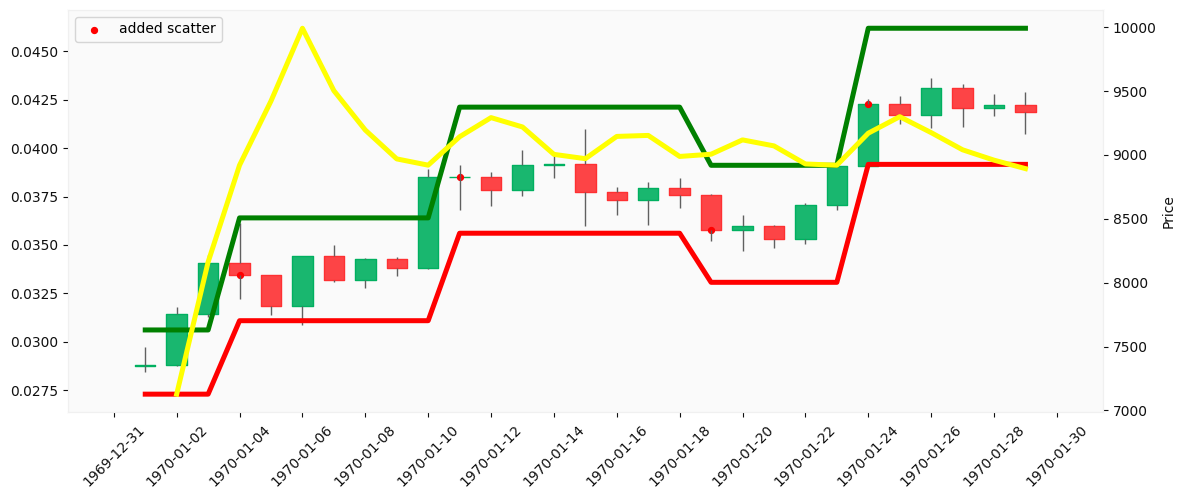

In [38]:
plot_first_window(tbl_df)

In [39]:
dates = tbl_df.index[0:5]
print(dates.to_pydatetime())

# Convert the pandas DatetimeIndex to matplotlib's date format
mpl_dates = mdates.date2num(dates.to_pydatetime())

# Now 'mpl_dates' can be used as input to matplotlib functions
print(mpl_dates)

[datetime.datetime(2020, 1, 4, 0, 0) datetime.datetime(2020, 1, 5, 0, 0)
 datetime.datetime(2020, 1, 6, 0, 0) datetime.datetime(2020, 1, 7, 0, 0)
 datetime.datetime(2020, 1, 8, 0, 0)]
[18265. 18266. 18267. 18268. 18269.]


In [40]:
import matplotlib.dates as mdates

# Your matplotlib date
mpl_date = 18265

# Convert it back to a datetime object
date = mdates.num2date(mpl_date)

print(date)


2020-01-04 00:00:00+00:00
